<a href="https://colab.research.google.com/github/arjun372/NE795-SciML/blob/main/Homework%204/Homework_4_Problem_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 2 - UQ with gPCE and MC sampling

## Part 1 - MC Sampling

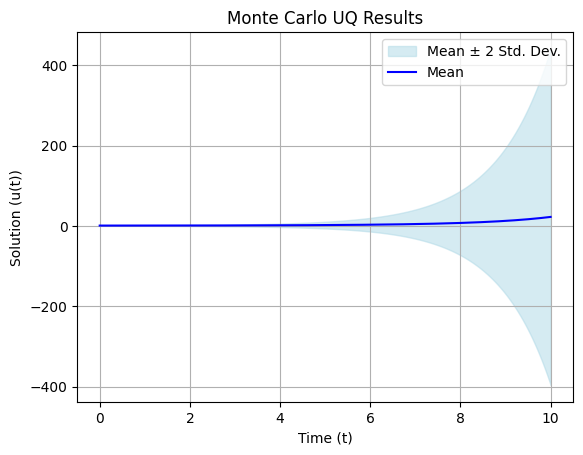

In [15]:
# Part 1 - MC Sampling

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define parameters
u0 = 1.0  # Initial condition
t_final = 10.0  # Final time
dt = 0.01  # Time step
num_samples = 1000  # Number of Monte Carlo samples
time_steps = int(t_final / dt)  # Number of time steps
k_mean = 0  # Mean of the Gaussian distribution for k(ω)
k_std = 0.25  # Standard deviation of the Gaussian distribution for k(ω)

# Define the ODE function
def dudt(u, k):
    return -k * u

# Initialize an array to store the solution for each sample
u_samples = np.zeros((num_samples, time_steps))

# Monte Carlo sampling
for i in range(num_samples):
    k_sample = norm.rvs(loc=k_mean, scale=k_std)  # Sample k(ω) from the Gaussian distribution
    u = u0  # Reset initial condition for each sample
    for j in range(time_steps):
        if j == 0:
            u_samples[i, j] = u  # Store the initial condition
        else:
            # Apply Euler's method to step forward in time
            u += dudt(u, k_sample) * dt
            u_samples[i, j] = u  # Store the result

# Calculate the mean and standard deviation across all samples at each time step
u_mean = np.mean(u_samples, axis=0)
u_std = np.std(u_samples, axis=0)

# Time vector for plotting
time = np.linspace(0, t_final, time_steps)

# Plotting the results
plt.fill_between(time, u_mean - 2 * u_std, u_mean + 2 * u_std, color='lightblue', alpha=0.5, label='Mean ± 2 Std. Dev.')
plt.plot(time, u_mean, label='Mean', color='blue')
plt.xlabel('Time (t)')
plt.ylabel('Solution (u(t))')
plt.title('Monte Carlo UQ Results')
plt.legend()
plt.grid(True)
plt.show()

## Part 2

In [3]:
! pip install chaospy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 14.4 MB/s eta 0:00:00


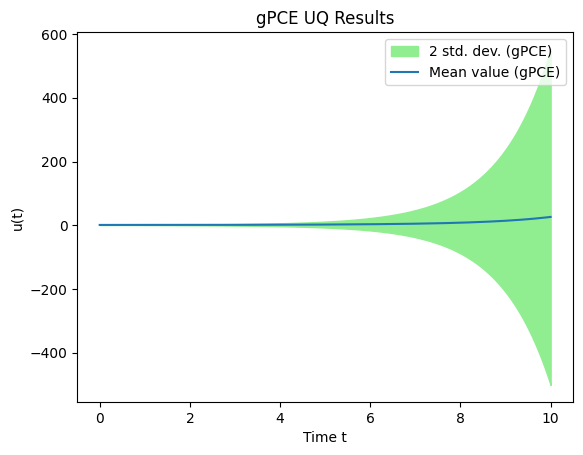

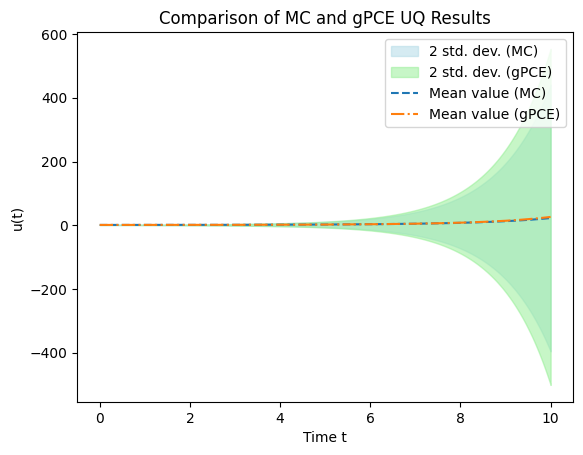

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import chaospy as cp

# Define parameters
u0 = 1.0
t_final = 10.0
dt = 0.01
num_samples = 1000
time_steps = int(t_final / dt)
k_std = 0.25

# Define the distribution for k(ω)
distribution = cp.Normal(0, k_std)

# Create orthogonal polynomials for gPCE using the updated function
polynomial_order = 8
polynomials = cp.expansion.stieltjes(polynomial_order, distribution)

# Define the ODE solver
def solve_ode(k_sample, time_steps):
    u_trajectory = np.empty(time_steps)
    u = u0
    for i in range(time_steps):
        u += -k_sample * u * dt
        u_trajectory[i] = u
    return u_trajectory

# Generate samples from the distribution
samples = distribution.sample(num_samples)

# Solve the ODE for each sample
u_evaluated = np.array([solve_ode(k, time_steps) for k in samples.T])

# Calculate mean and standard deviation
u_mean_gPCE = np.mean(u_evaluated, axis=0)
u_std_gPCE = np.std(u_evaluated, axis=0)

# Plotting the results
time = np.linspace(0, t_final, time_steps)
plt.fill_between(time, u_mean_gPCE - 2 * u_std_gPCE, u_mean_gPCE + 2 * u_std_gPCE, color='lightgreen', label='2 std. dev. (gPCE)')
plt.plot(time, u_mean_gPCE, label='Mean value (gPCE)')
plt.xlabel('Time t')
plt.ylabel('u(t)')
plt.title('gPCE UQ Results')
plt.legend()
plt.show()

plt.fill_between(time, u_mean - 2 * u_std, u_mean + 2 * u_std, color='lightblue', alpha=0.5, label='2 std. dev. (MC)')
plt.fill_between(time, u_mean_gPCE - 2 * u_std_gPCE, u_mean_gPCE + 2 * u_std_gPCE, color='lightgreen', alpha=0.5, label='2 std. dev. (gPCE)')
plt.plot(time, u_mean, label='Mean value (MC)', linestyle='--')
plt.plot(time, u_mean_gPCE, label='Mean value (gPCE)', linestyle='-.')
plt.xlabel('Time t')
plt.ylabel('u(t)')
plt.title('Comparison of MC and gPCE UQ Results')
plt.legend()
plt.show()

## Part 3 - Observing Convergence with increasing degree

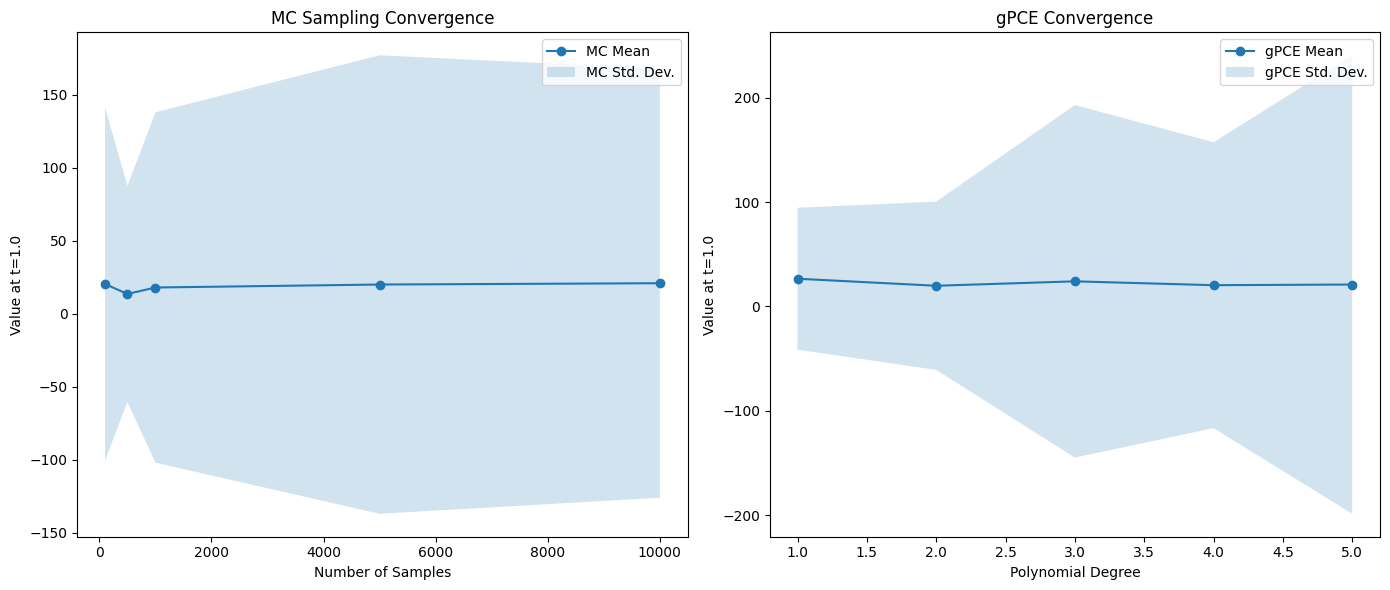

In [21]:
### Part 3: Observing Convergence

import numpy as np
import chaospy as cp
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define parameters
u0 = 1.0
t_final = 10.0
dt = 0.01
time_steps = int(t_final / dt)
k_std = 0.25

# Define the ODE function
def dudt(u, k):
    return -k * u

# Monte Carlo sampling function
def monte_carlo_sampling(num_samples):
    u_samples = np.zeros((num_samples, time_steps))
    k_samples = norm.rvs(loc=0, scale=k_std, size=num_samples)

    for i in range(num_samples):
        u = u0
        for j in range(time_steps):
            u += dudt(u, k_samples[i]) * dt
            u_samples[i, j] = u

    return np.mean(u_samples[:, -1]), np.std(u_samples[:, -1])

# gPCE function
def gPCE(polynomial_order, num_samples):
    distribution = cp.Normal(0, k_std)
    polynomials = cp.expansion.stieltjes(polynomial_order, distribution)
    samples = distribution.sample(num_samples)
    u_samples = np.array([u0 * np.exp(-k * t_final) for k in samples])

    # Fit the polynomial chaos expansion
    gPCE_approximation = cp.fit_regression(polynomials, samples, u_samples)

    # Calculate statistics
    mean_gPCE = cp.E(gPCE_approximation, distribution)
    std_gPCE = cp.Std(gPCE_approximation, distribution)

    return mean_gPCE, std_gPCE

# Define the range of polynomial degrees and sample sizes
poly_degrees = [1, 2, 3, 4, 5]
sample_sizes = [100, 500, 1000, 5000, 10000]

# Collect results
mc_results = []
gPCE_results = []

for n in sample_sizes:
    mc_mean, mc_std = monte_carlo_sampling(n)
    mc_results.append((mc_mean, mc_std))

for p in poly_degrees:
    gPCE_mean, gPCE_std = gPCE(p, max(sample_sizes))  # Use the largest sample size for gPCE
    gPCE_results.append((gPCE_mean, gPCE_std))

# Plot the results
plt.figure(figsize=(14, 6))

# MC results
mc_means, mc_stds = zip(*mc_results)
plt.subplot(1, 2, 1)
plt.plot(sample_sizes, mc_means, 'o-', label='MC Mean')
plt.fill_between(sample_sizes, np.array(mc_means) - np.array(mc_stds), np.array(mc_means) + np.array(mc_stds), alpha=0.2, label='MC Std. Dev.')
plt.xlabel('Number of Samples')
plt.ylabel('Value at t=1.0')
plt.title('MC Sampling Convergence')
plt.legend()

# gPCE results
gPCE_means, gPCE_stds = zip(*gPCE_results)
plt.subplot(1, 2, 2)
plt.plot(poly_degrees, gPCE_means, 'o-', label='gPCE Mean')
plt.fill_between(poly_degrees, np.array(gPCE_means) - np.array(gPCE_stds), np.array(gPCE_means) + np.array(gPCE_stds), alpha=0.2, label='gPCE Std. Dev.')
plt.xlabel('Polynomial Degree')
plt.ylabel('Value at t=1.0')
plt.title('gPCE Convergence')
plt.legend()

plt.tight_layout()
plt.show()

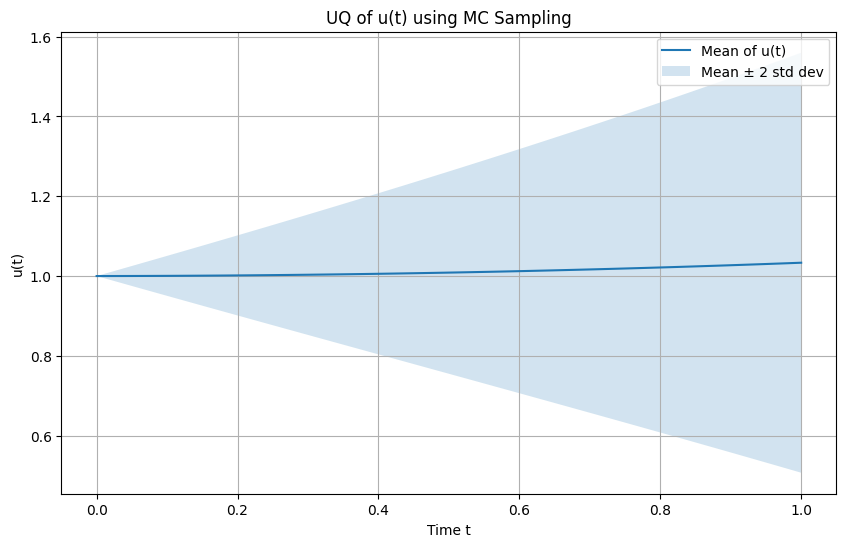

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import odeint

# Define the ODE function
def ode_system(u, t, k):
    return -k * u

# Initial condition
u0 = 1.0

# Time points
t = np.linspace(0, 1, 100)

# Number of samples for MC
num_samples = 10000

# Sample k(ω) from the Gaussian distribution
k_samples = norm.rvs(loc=0, scale=0.25, size=num_samples)

# Solve the ODE for each sample of k and store the results
u_samples = np.zeros((num_samples, len(t)))
for i, k in enumerate(k_samples):
    u_samples[i, :] = odeint(ode_system, u0, t, args=(k,)).flatten()

# Compute the mean and standard deviation at each time point
u_mean = np.mean(u_samples, axis=0)
u_std = np.std(u_samples, axis=0)

# Plot the mean and confidence interval
plt.figure(figsize=(10, 6))
plt.plot(t, u_mean, label='Mean of u(t)')
plt.fill_between(t, u_mean - 2 * u_std, u_mean + 2 * u_std, alpha=0.2, label='Mean ± 2 std dev')
plt.title('UQ of u(t) using MC Sampling')
plt.xlabel('Time t')
plt.ylabel('u(t)')
plt.legend()
plt.grid(True)
plt.show()



chaospy.orth_ttr name is to be deprecated; Use chaospy.expansion.stieltjes instead


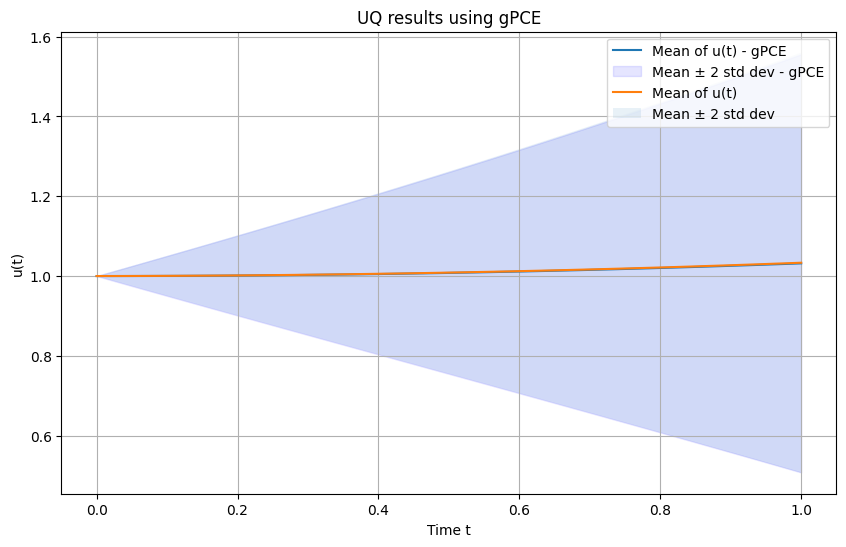

In [51]:
import chaospy as cp
import numpy as np
import matplotlib.pyplot as plt

# Define the parameters
u0 = 1.0  # Initial condition
t = np.linspace(0, 1, 100)  # Time points
k_mean = 0  # Mean of k(ω)
k_std = 0.25  # Standard deviation of k(ω)

# Define the distribution of k(ω)
distribution = cp.Normal(k_mean, k_std)

# Create orthogonal polynomials for gPCE
order = 4  # Polynomial order
polynomials = cp.orth_ttr(order, distribution)

# Define the model function for a scalar k
def model_scalar(k, t):
    return u0 * np.exp(-k * t)

# Generate samples and evaluate the model
num_samples = 10000  # Number of samples for the gPCE
samples = distribution.sample(num_samples, rule='R')
evals = np.array([model_scalar(k, t) for k in samples.T])

# Fit the regression model to the samples
coefficients = cp.fit_regression(polynomials, samples, evals)

# Calculate the mean and standard deviation using the gPCE coefficients
u_mean_gPCE = cp.E(coefficients, distribution)
u_std_gPCE = cp.Std(coefficients, distribution)

# Plot the gPCE results
plt.figure(figsize=(10, 6))
plt.plot(t, u_mean_gPCE, label='Mean of u(t) - gPCE')
plt.fill_between(t, u_mean_gPCE - 2 * u_std_gPCE, u_mean_gPCE + 2 * u_std_gPCE, color='blue', alpha=0.1, label='Mean ± 2 std dev - gPCE')

# Assuming you have already computed u_mean and u_std from the MC sampling
# plt.plot(t, u_mean, 'k--', label='Mean of u(t) - MC')
# plt.fill_between(t, u_mean - 2 * u_std, u_mean + 2 * u_std, color='gray', alpha=0.5, label='Mean ± 2 std dev - MC')
plt.plot(t, u_mean, label='Mean of u(t)')
plt.fill_between(t, u_mean - 2 * u_std, u_mean + 2 * u_std, alpha=0.1, label='Mean ± 2 std dev')
plt.title('UQ results using gPCE')
plt.xlabel('Time t')
plt.ylabel('u(t)')
plt.legend()
plt.grid(True)
plt.show()

chaospy.orth_ttr name is to be deprecated; Use chaospy.expansion.stieltjes instead


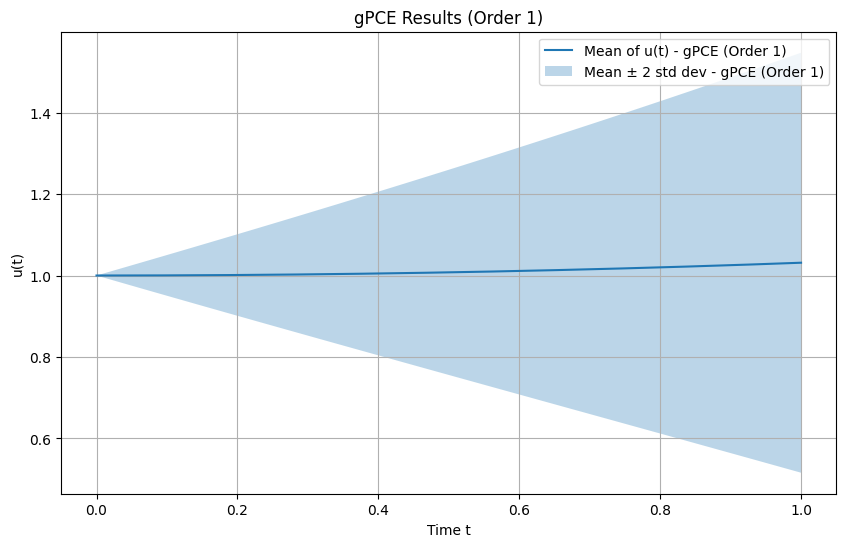

chaospy.orth_ttr name is to be deprecated; Use chaospy.expansion.stieltjes instead


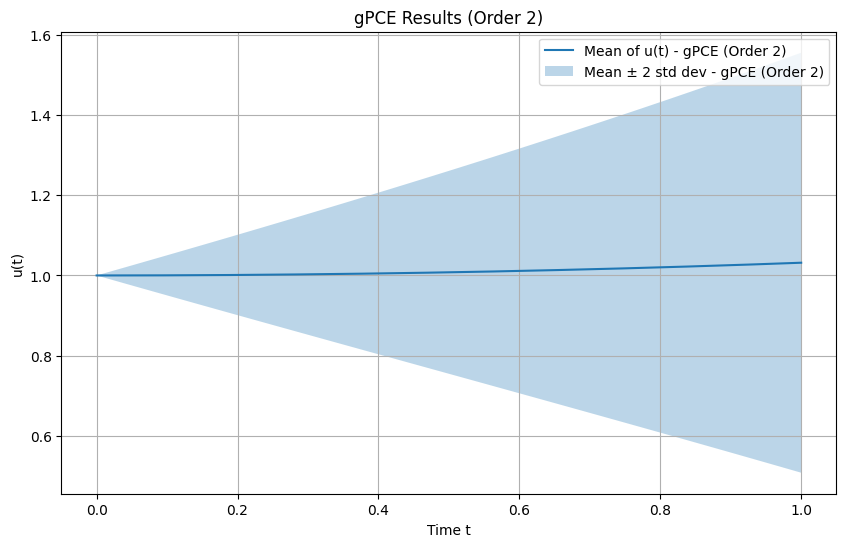

chaospy.orth_ttr name is to be deprecated; Use chaospy.expansion.stieltjes instead


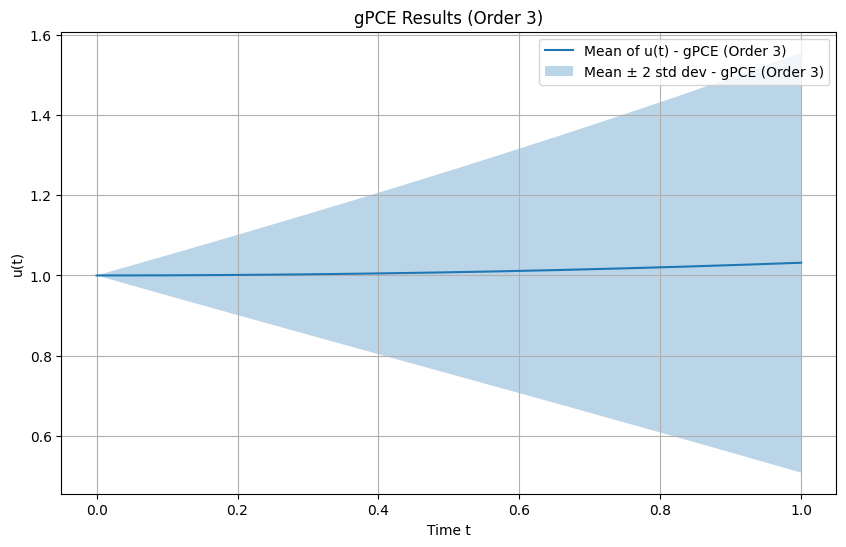

chaospy.orth_ttr name is to be deprecated; Use chaospy.expansion.stieltjes instead


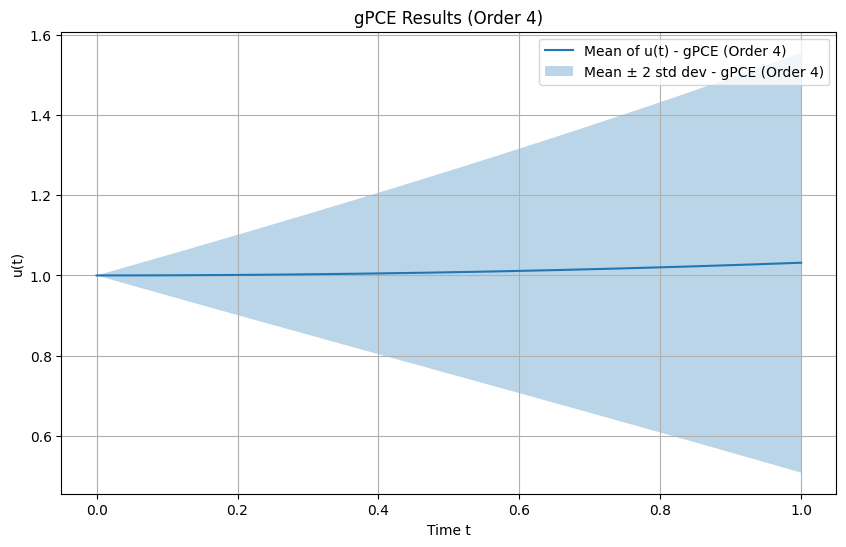

chaospy.orth_ttr name is to be deprecated; Use chaospy.expansion.stieltjes instead


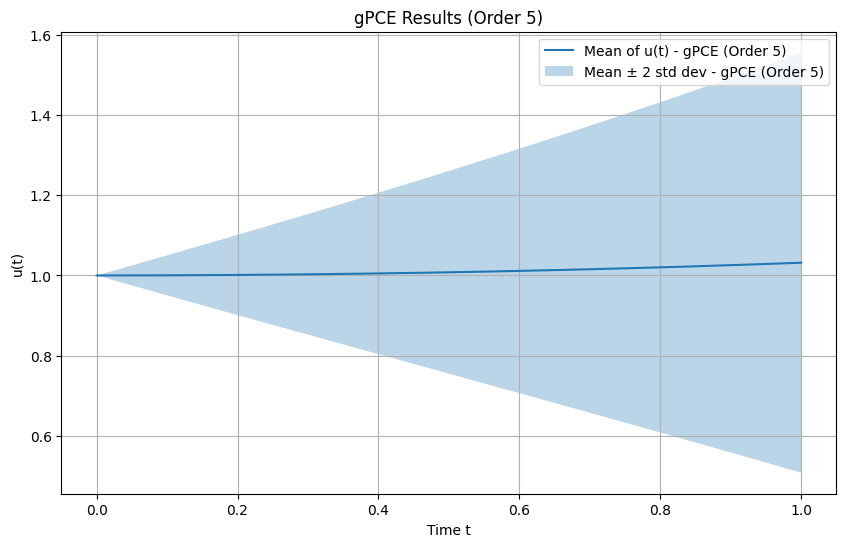

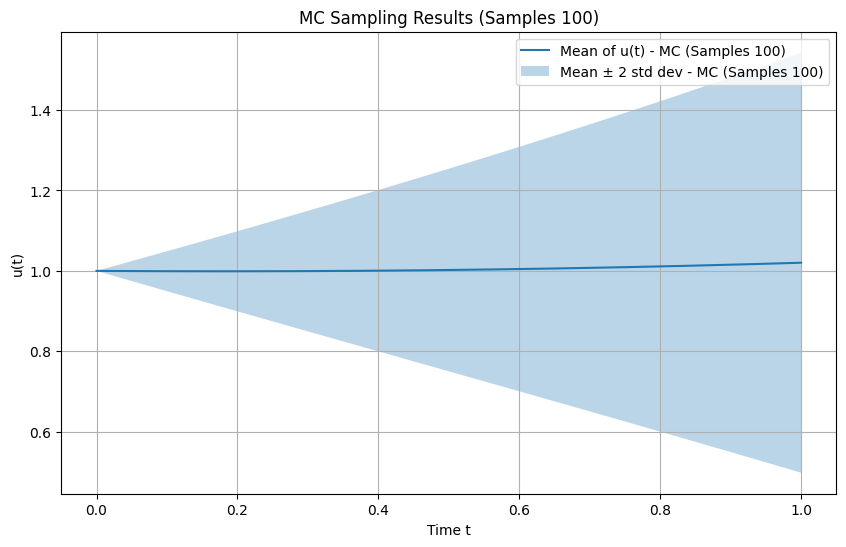

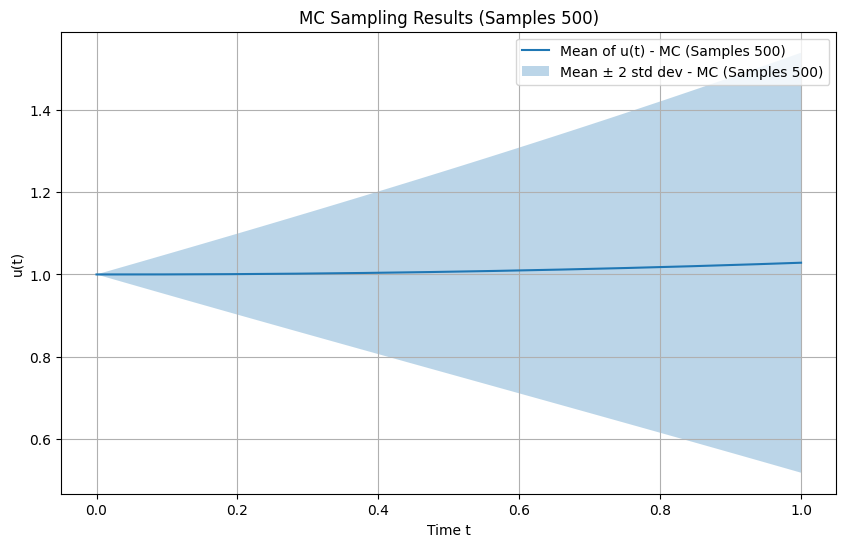

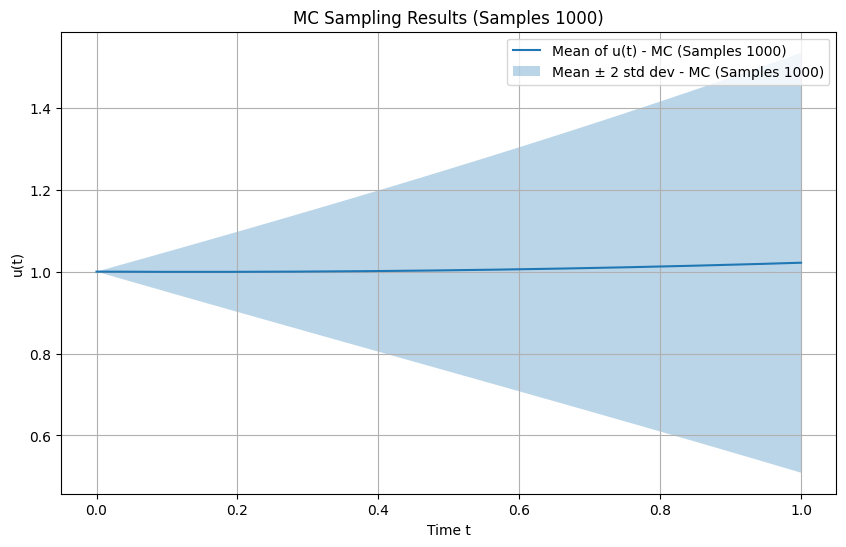

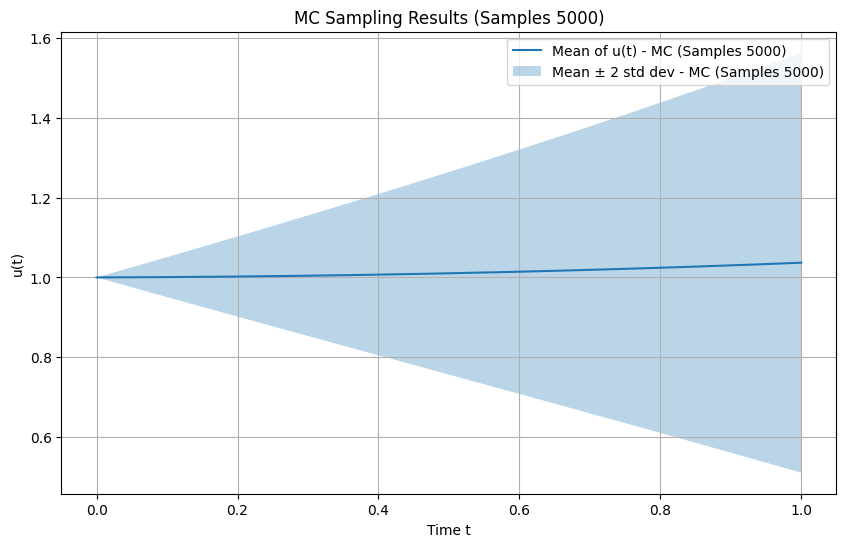

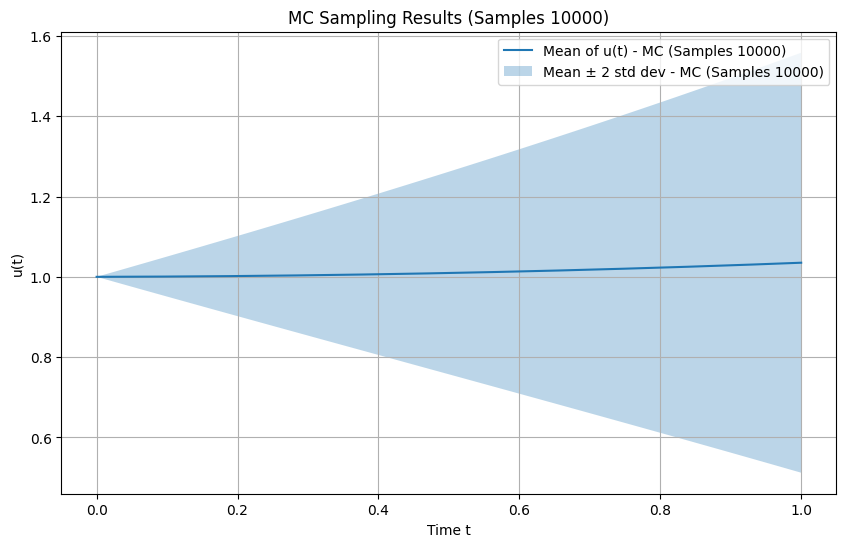

chaospy.orth_ttr name is to be deprecated; Use chaospy.expansion.stieltjes instead


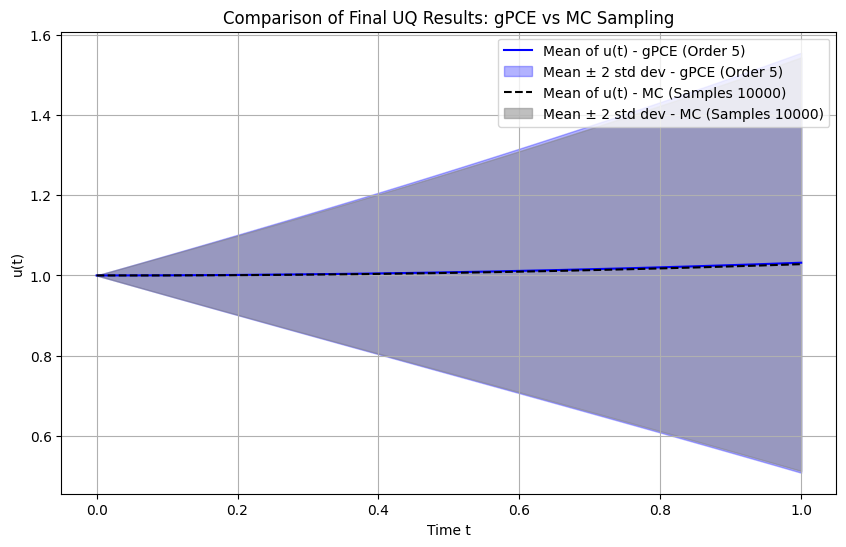

In [43]:
import chaospy as cp
import numpy as np
import matplotlib.pyplot as plt

# Define the parameters
u0 = 1.0  # Initial condition
t = np.linspace(0, 1, 1000)  # Time points
k_mean = 0  # Mean of k(ω)
k_std = 0.25  # Standard deviation of k(ω)
distribution = cp.Normal(k_mean, k_std)  # Define the distribution of k(ω)

# Define the model function for a scalar k
def model_scalar(k, t):
    return u0 * np.exp(-k * t)

# Function to perform gPCE
def perform_gPCE(order, num_samples):
    polynomials = cp.orth_ttr(order, distribution)
    samples = distribution.sample(num_samples, rule='R')
    evals = np.array([model_scalar(k, t) for k in samples.T])
    coefficients = cp.fit_regression(polynomials, samples, evals)
    u_mean_gPCE = cp.E(coefficients, distribution)
    u_std_gPCE = cp.Std(coefficients, distribution)
    return u_mean_gPCE, u_std_gPCE

# Function to perform MC sampling
def perform_MC(num_samples):
    k_samples = np.random.normal(k_mean, k_std, num_samples)
    u_samples = np.array([u0 * np.exp(-k * t) for k in k_samples])
    u_mean_MC = np.mean(u_samples, axis=0)
    u_std_MC = np.std(u_samples, axis=0)
    return u_mean_MC, u_std_MC

# Experiment settings
gPCE_orders = [1, 2, 3, 4, 5]  # Polynomial degrees for gPCE
MC_sample_sizes = [100, 500, 1000, 5000, 10000]  # Number of samples for MC

# Perform experiments
for order in gPCE_orders:
    u_mean_gPCE, u_std_gPCE = perform_gPCE(order, MC_sample_sizes[-1])
    plt.figure(figsize=(10, 6))
    plt.plot(t, u_mean_gPCE, label=f'Mean of u(t) - gPCE (Order {order})')
    plt.fill_between(t, u_mean_gPCE - 2 * u_std_gPCE, u_mean_gPCE + 2 * u_std_gPCE, alpha=0.3, label=f'Mean ± 2 std dev - gPCE (Order {order})')
    plt.title(f'gPCE Results (Order {order})')
    plt.xlabel('Time t')
    plt.ylabel('u(t)')
    plt.legend()
    plt.grid(True)
    plt.show()

for num_samples in MC_sample_sizes:
    u_mean_MC, u_std_MC = perform_MC(num_samples)
    plt.figure(figsize=(10, 6))
    plt.plot(t, u_mean_MC, label=f'Mean of u(t) - MC (Samples {num_samples})')
    plt.fill_between(t, u_mean_MC - 2 * u_std_MC, u_mean_MC + 2 * u_std_MC, alpha=0.3, label=f'Mean ± 2 std dev - MC (Samples {num_samples})')
    plt.title(f'MC Sampling Results (Samples {num_samples})')
    plt.xlabel('Time t')
    plt.ylabel('u(t)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Compare the final results from both methods
u_mean_gPCE_final, u_std_gPCE_final = perform_gPCE(gPCE_orders[-1], MC_sample_sizes[-1])
u_mean_MC_final, u_std_MC_final = perform_MC(MC_sample_sizes[-1])

plt.figure(figsize=(10, 6))
plt.plot(t, u_mean_gPCE_final, 'b-', label=f'Mean of u(t) - gPCE (Order {gPCE_orders[-1]})')
plt.fill_between(t, u_mean_gPCE_final - 2 * u_std_gPCE_final, u_mean_gPCE_final + 2 * u_std_gPCE_final, color='blue', alpha=0.3, label=f'Mean ± 2 std dev - gPCE (Order {gPCE_orders[-1]})')
plt.plot(t, u_mean_MC_final, 'k--', label=f'Mean of u(t) - MC (Samples {MC_sample_sizes[-1]})')
plt.fill_between(t, u_mean_MC_final - 2 * u_std_MC_final, u_mean_MC_final + 2 * u_std_MC_final, color='gray', alpha=0.5, label=f'Mean ± 2 std dev - MC (Samples {MC_sample_sizes[-1]})')
plt.title('Comparison of Final UQ Results: gPCE vs MC Sampling')
plt.xlabel('Time t')
plt.ylabel('u(t)')
plt.legend()
plt.grid(True)
plt.show()

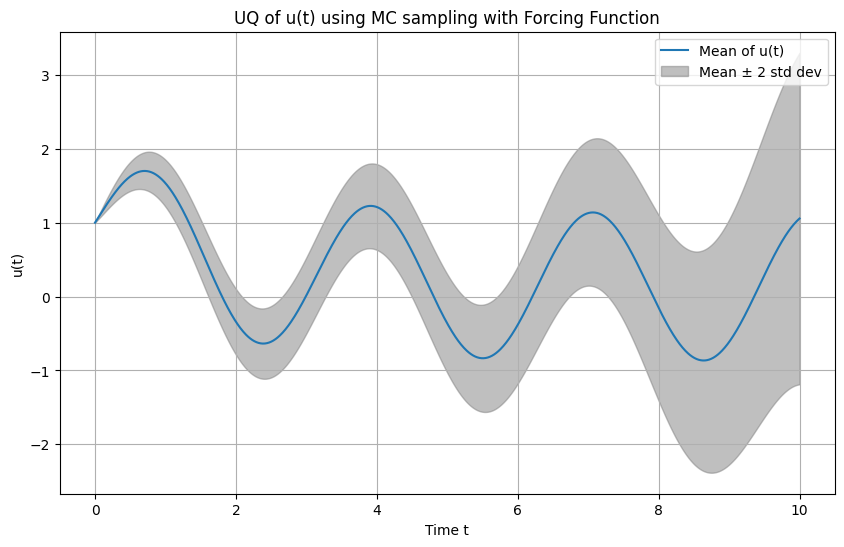

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Define the parameters
u0 = 1.0  # Initial condition
t = np.linspace(0, 10, 1000)  # Extend the time interval
num_samples = 10000  # Number of MC samples
k_mean = 0.5  # Increase the mean of k(ω)
k_std = 0.25  # Standard deviation of k(ω)
omega = 2.0  # Frequency of the forcing function

# Sample k(ω) from the Gaussian distribution
k_samples = np.random.normal(k_mean, k_std, num_samples)

# Solve the ODE for each sample of k(ω)
u_samples = np.array([u0 * np.exp(-k * t) + np.sin(omega * t) for k in k_samples])

# Compute the mean and standard deviation of u(t) at each time point
u_mean = np.mean(u_samples, axis=0)
u_std = np.std(u_samples, axis=0)

# Plot the mean and confidence interval
plt.figure(figsize=(10, 6))
plt.plot(t, u_mean, label='Mean of u(t)')
plt.fill_between(t, u_mean - 2 * u_std, u_mean + 2 * u_std, color='gray', alpha=0.5, label='Mean ± 2 std dev')
plt.title('UQ of u(t) using MC sampling with Forcing Function')
plt.xlabel('Time t')
plt.ylabel('u(t)')
plt.legend()
plt.grid(True)
plt.show()

chaospy.orth_ttr name is to be deprecated; Use chaospy.expansion.stieltjes instead


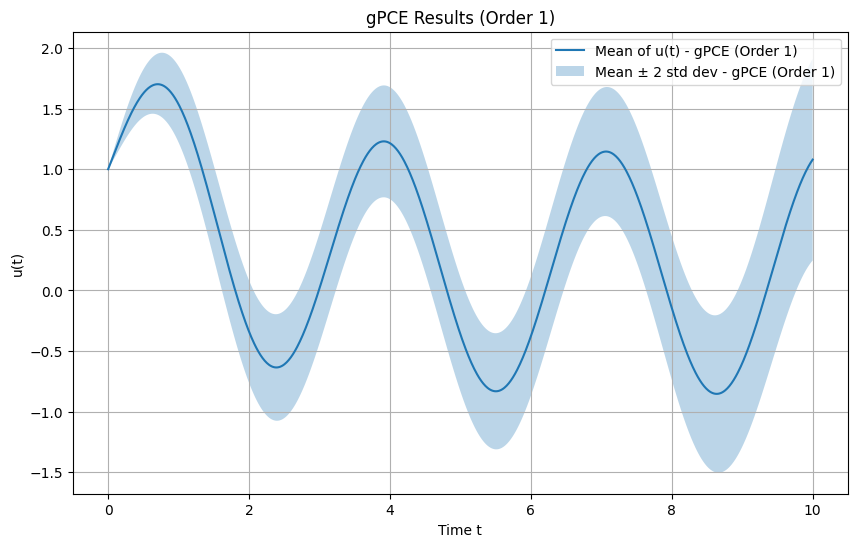

chaospy.orth_ttr name is to be deprecated; Use chaospy.expansion.stieltjes instead


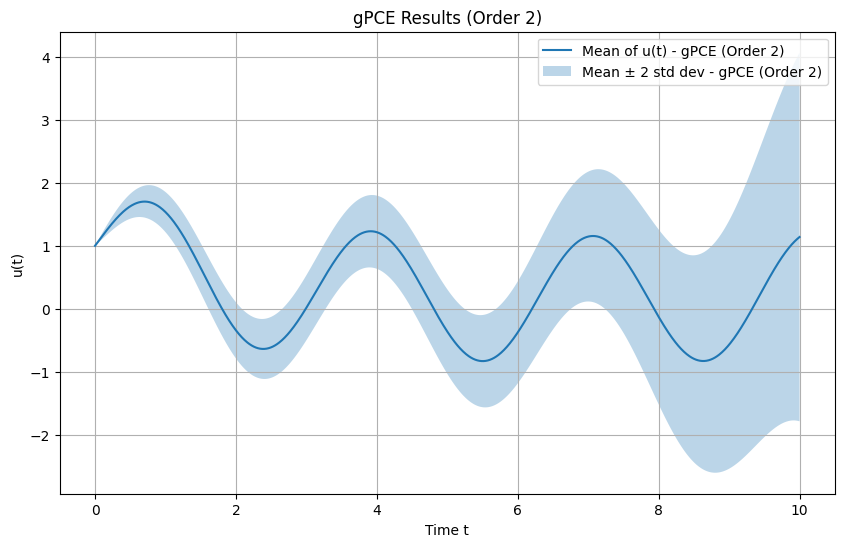

chaospy.orth_ttr name is to be deprecated; Use chaospy.expansion.stieltjes instead


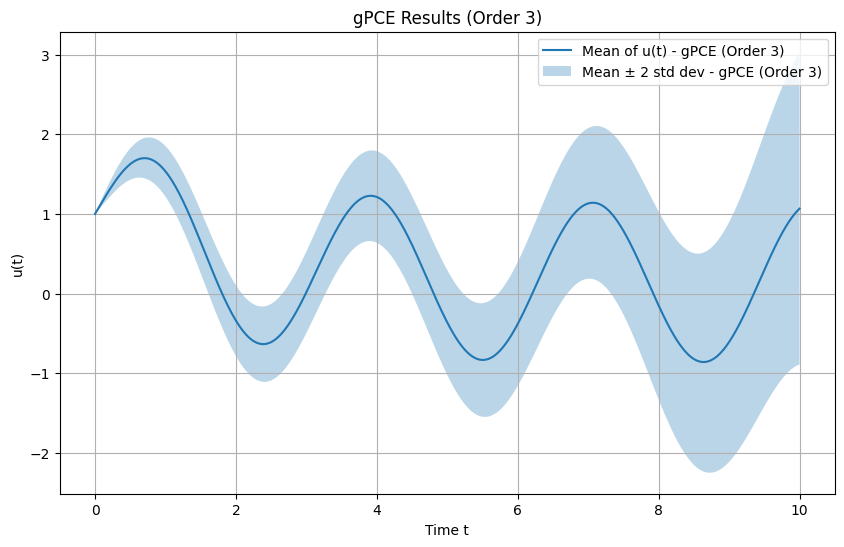

chaospy.orth_ttr name is to be deprecated; Use chaospy.expansion.stieltjes instead


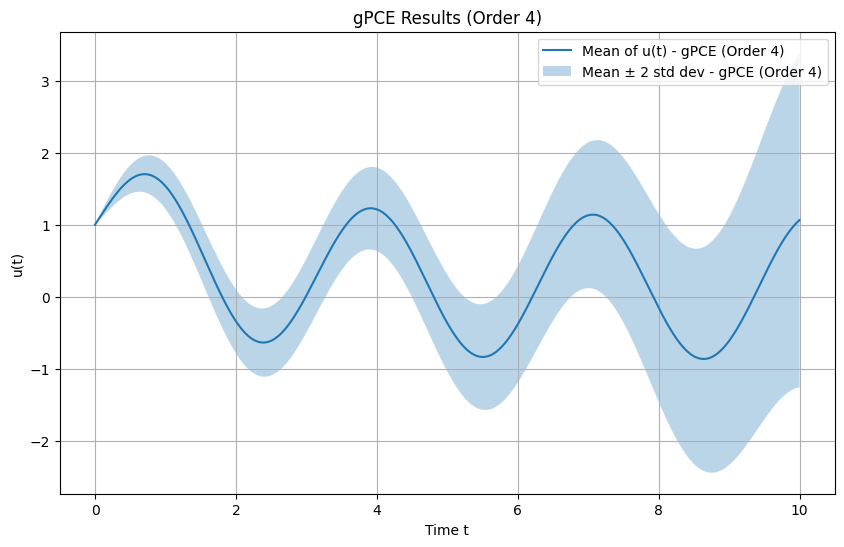

chaospy.orth_ttr name is to be deprecated; Use chaospy.expansion.stieltjes instead


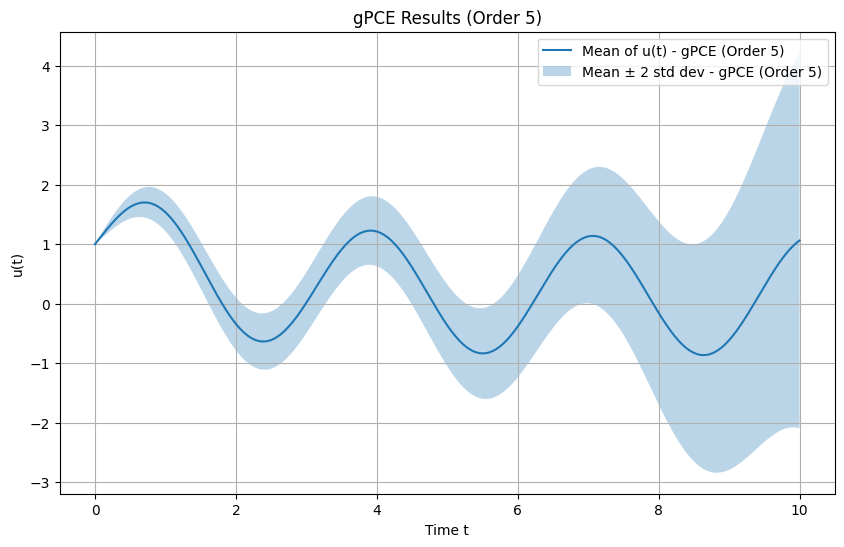

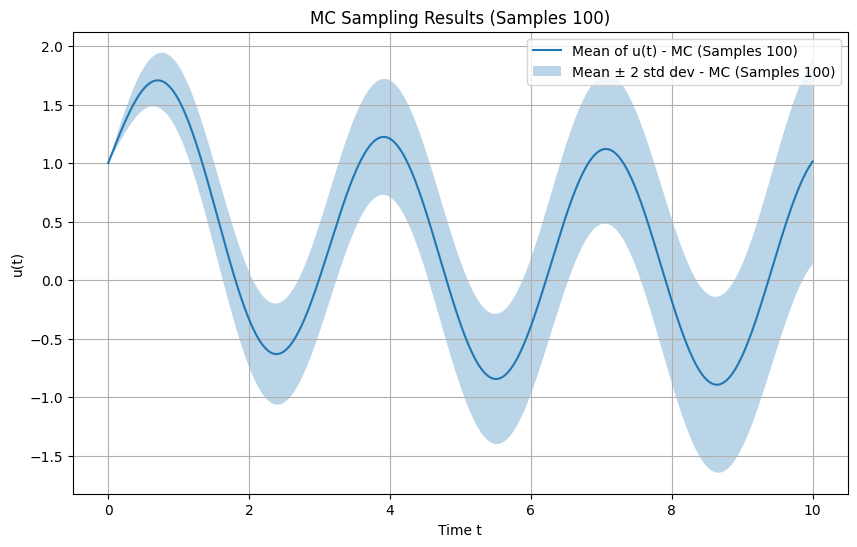

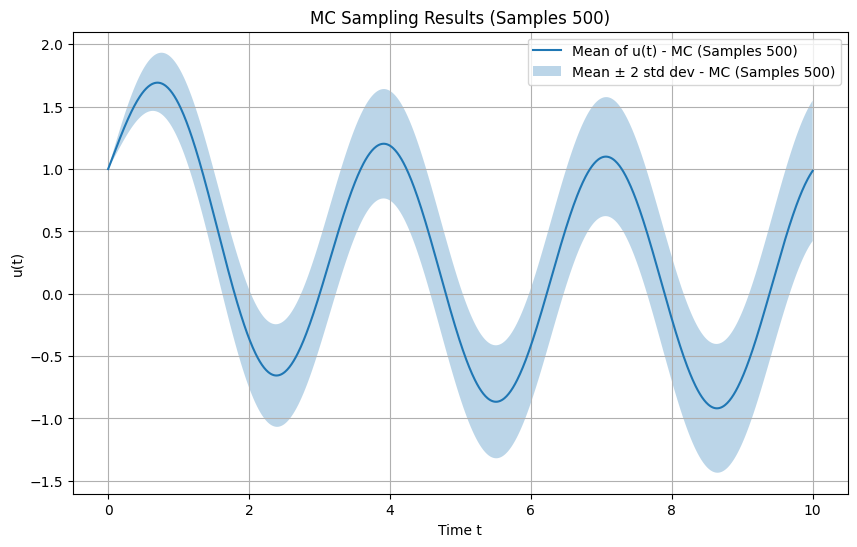

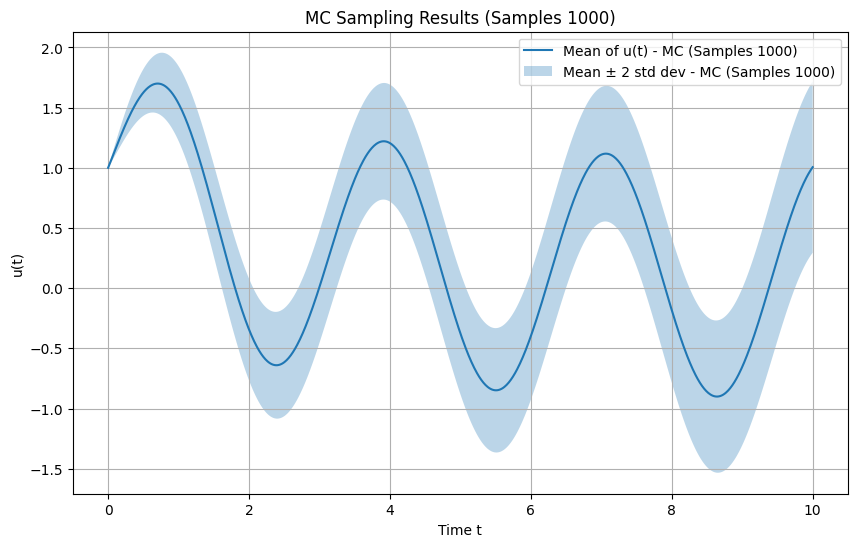

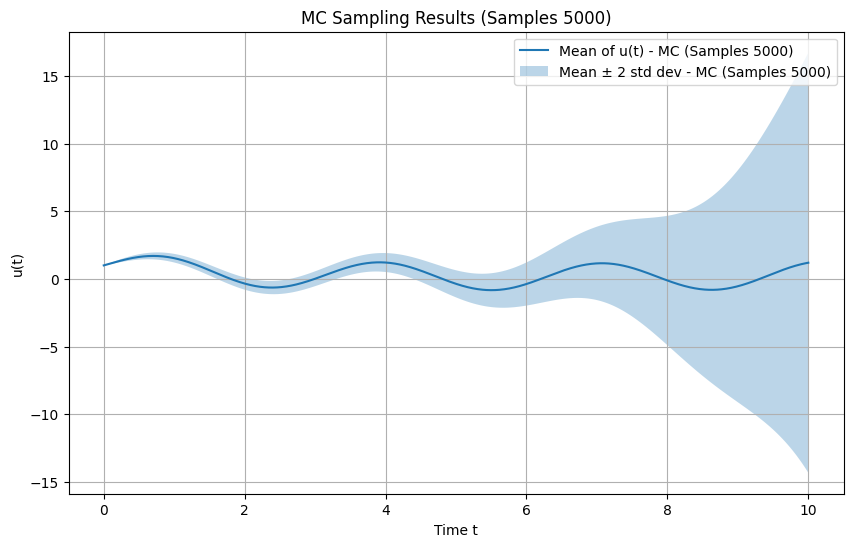

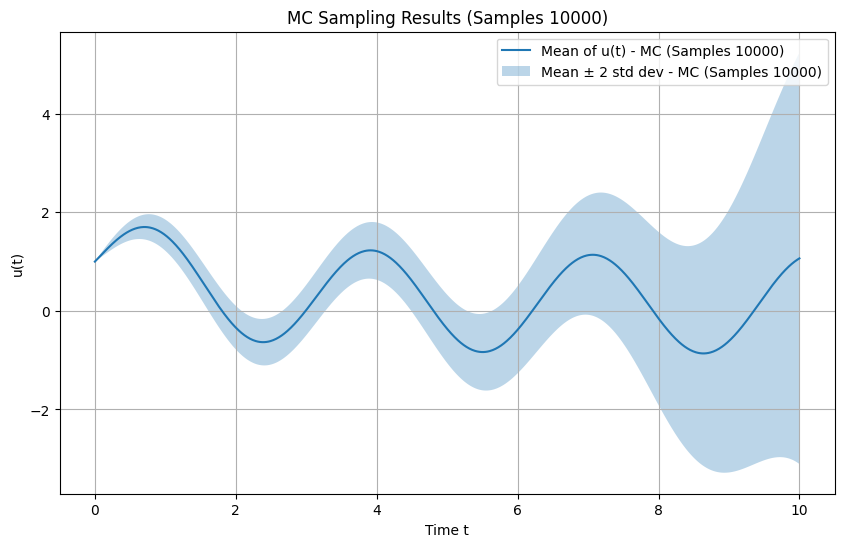

chaospy.orth_ttr name is to be deprecated; Use chaospy.expansion.stieltjes instead


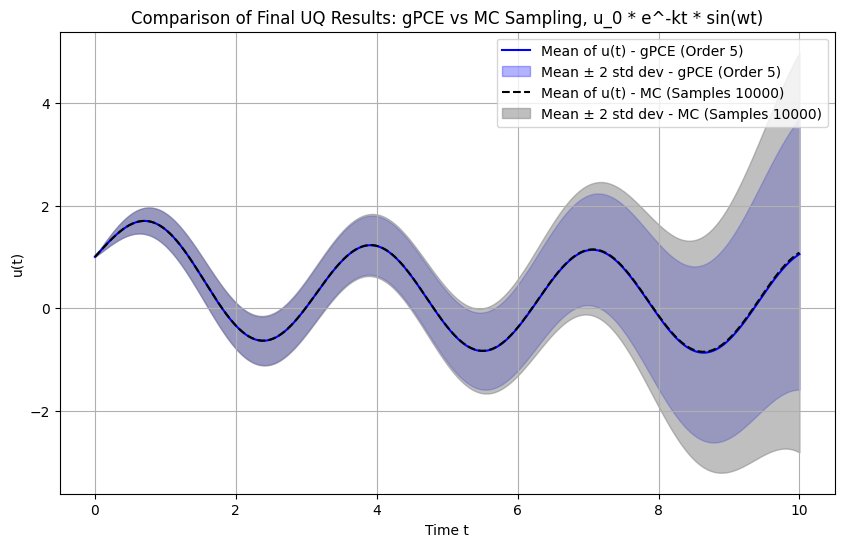

In [52]:
import chaospy as cp
import numpy as np
import matplotlib.pyplot as plt

# Define the parameters
u0 = 1.0  # Initial condition
t = np.linspace(0, 10, 1000)  # Extend the time interval
#num_samples = 10000  # Number of MC samples
k_mean = 0.5  # Increase the mean of k(ω)
k_std = 0.25  # Standard deviation of k(ω)
omega = 2.0  # Frequency of the forcing function

distribution = cp.Normal(k_mean, k_std)  # Define the distribution of k(ω)

# Define the model function for a scalar k
def model_scalar(k, t):
    return u0 * np.exp(-k * t) + np.sin(omega * t)

# Function to perform gPCE
def perform_gPCE(order, num_samples):
    polynomials = cp.orth_ttr(order, distribution)
    samples = distribution.sample(num_samples, rule='R')
    evals = np.array([model_scalar(k, t) for k in samples.T])
    coefficients = cp.fit_regression(polynomials, samples, evals)
    u_mean_gPCE = cp.E(coefficients, distribution)
    u_std_gPCE = cp.Std(coefficients, distribution)
    return u_mean_gPCE, u_std_gPCE

# Function to perform MC sampling
def perform_MC(num_samples):
    k_samples = np.random.normal(k_mean, k_std, num_samples)
    u_samples = np.array([model_scalar(k, t) for k in k_samples])
    u_mean_MC = np.mean(u_samples, axis=0)
    u_std_MC = np.std(u_samples, axis=0)
    return u_mean_MC, u_std_MC

# Experiment settings
gPCE_orders = [1, 2, 3, 4, 5]  # Polynomial degrees for gPCE
MC_sample_sizes = [100, 500, 1000, 5000, 10000]  # Number of samples for MC

# Perform experiments
for order in gPCE_orders:
    u_mean_gPCE, u_std_gPCE = perform_gPCE(order, MC_sample_sizes[-1])
    plt.figure(figsize=(10, 6))
    plt.plot(t, u_mean_gPCE, label=f'Mean of u(t) - gPCE (Order {order})')
    plt.fill_between(t, u_mean_gPCE - 2 * u_std_gPCE, u_mean_gPCE + 2 * u_std_gPCE, alpha=0.3, label=f'Mean ± 2 std dev - gPCE (Order {order})')
    plt.title(f'gPCE Results (Order {order})')
    plt.xlabel('Time t')
    plt.ylabel('u(t)')
    plt.legend()
    plt.grid(True)
    plt.show()

for num_samples in MC_sample_sizes:
    u_mean_MC, u_std_MC = perform_MC(num_samples)
    plt.figure(figsize=(10, 6))
    plt.plot(t, u_mean_MC, label=f'Mean of u(t) - MC (Samples {num_samples})')
    plt.fill_between(t, u_mean_MC - 2 * u_std_MC, u_mean_MC + 2 * u_std_MC, alpha=0.3, label=f'Mean ± 2 std dev - MC (Samples {num_samples})')
    plt.title(f'MC Sampling Results (Samples {num_samples})')
    plt.xlabel('Time t')
    plt.ylabel('u(t)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Compare the final results from both methods
u_mean_gPCE_final, u_std_gPCE_final = perform_gPCE(gPCE_orders[-1], MC_sample_sizes[-1])
u_mean_MC_final, u_std_MC_final = perform_MC(MC_sample_sizes[-1])

plt.figure(figsize=(10, 6))
plt.plot(t, u_mean_gPCE_final, 'b-', label=f'Mean of u(t) - gPCE (Order {gPCE_orders[-1]})')
plt.fill_between(t, u_mean_gPCE_final - 2 * u_std_gPCE_final, u_mean_gPCE_final + 2 * u_std_gPCE_final, color='blue', alpha=0.3, label=f'Mean ± 2 std dev - gPCE (Order {gPCE_orders[-1]})')
plt.plot(t, u_mean_MC_final, 'k--', label=f'Mean of u(t) - MC (Samples {MC_sample_sizes[-1]})')
plt.fill_between(t, u_mean_MC_final - 2 * u_std_MC_final, u_mean_MC_final + 2 * u_std_MC_final, color='gray', alpha=0.5, label=f'Mean ± 2 std dev - MC (Samples {MC_sample_sizes[-1]})')
plt.title('Comparison of Final UQ Results: gPCE vs MC Sampling, u_0 * e^-kt * sin(wt)')
plt.xlabel('Time t')
plt.ylabel('u(t)')
plt.legend()
plt.grid(True)
plt.show()